# KMeans: Scitkit, Pilot and Spark/MLlib


This is perhaps the best known database to be found in the pattern recognition literature. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant (see <https://archive.ics.uci.edu/ml/datasets/Iris>). 

Source: R. A. Fisher, The Use of Multiple Measurements in Taxonomic Problems, 1936, http://rcs.chemometrics.ru/Tutorials/classification/Fisher.pdf

Pictures (Source [Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set))

<table>
<tr><td>
Setosa
</td><td>
Versicolor
</td><td>
Virginica
</td></tr>
<tr><td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg/180px-Kosaciec_szczecinkowaty_Iris_setosa.jpg"/> 
</td><td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Iris_versicolor_3.jpg/320px-Iris_versicolor_3.jpg"/>
</td><td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/295px-Iris_virginica.jpg"/>
</td></tr></table>

## 1. Data Overview

We will begin by loading the data into a Pandas dataframe.

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/pydata/pandas/master/pandas/tests/data/iris.csv")
data.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## 2. Scikit

Scikit is a machine learning library for Python built upon numpy and matplotlib. It provides functions for classification, regression, clustering and other common analytics tasks.

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
results = kmeans.fit_predict(data[['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']])

In [4]:
data_kmeans=pd.concat([data, pd.Series(results, name="ClusterId")], axis=1)
data_kmeans.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name,ClusterId
0,5.1,3.5,1.4,0.2,Iris-setosa,1
1,4.9,3.0,1.4,0.2,Iris-setosa,1
2,4.7,3.2,1.3,0.2,Iris-setosa,1
3,4.6,3.1,1.5,0.2,Iris-setosa,1
4,5.0,3.6,1.4,0.2,Iris-setosa,1


In the following we evaluate the resulting fit (commonly referred to as the model), using the sum of squared errors and a pair plot. The following pair plot shows the scatter-plot between each of the four features. Clusters for the different species are indicated by different colors.

In [5]:
print "Sum of squared error: %.1f"%kmeans.inertia_

Sum of squared error: 78.9


2015-11-15 03:57:41,070: radical.saga.cpi    : MainProcess                     : Thread-16      : ERROR   : monitoring channel failed -- disable notifications
2015-11-15 03:57:41,070: radical.saga.cpi    : MainProcess                     : Thread-17      : ERROR   : monitoring channel failed -- disable notifications


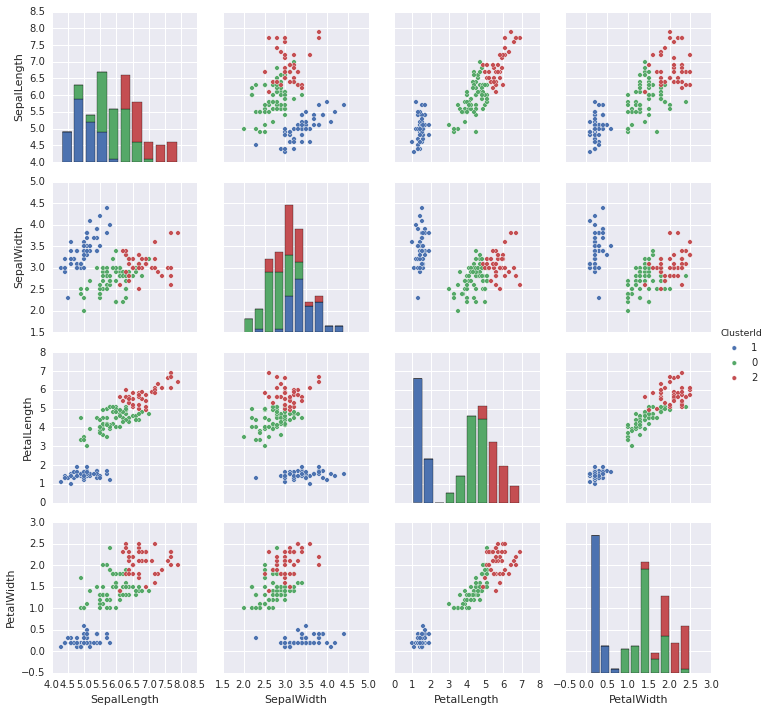

In [23]:
sns.pairplot(data_kmeans, vars=["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"], hue="ClusterId");

## 3. Pilot Approach

We will now use RADICAL-Pilot to compute the distance function, as a simple representation of how the above example can be executed as a task-parallel application.

In [7]:
import os, sys
import commands
import radical.pilot as rp
os.environ["RADICAL_PILOT_DBURL"]="mongodb://ec2-54-221-194-147.compute-1.amazonaws.com:24242/giannis"

def print_details(detail_object):
    if type(detail_object)==str:
        detail_object = ast.literal_eval(detail_object)
    for i in detail_object:
        detail_object[i]=str(detail_object[i])
    #print str(detail_object)
    return pd.DataFrame(detail_object.values(), 
             index=detail_object.keys(), 
             columns=["Value"])


session = rp.Session()
c = rp.Context('ssh')
c.user_id = "radical"
session.add_context(c)
pmgr = rp.PilotManager(session=session)
umgr = rp.UnitManager (session=session,
                       scheduler=rp.SCHED_DIRECT_SUBMISSION)
print "Session id: %s Pilot Manager: %s" % (session.uid, str(pmgr.as_dict()))
pdesc = rp.ComputePilotDescription ()
pdesc.resource = "local.localhost_anaconda"
pdesc.runtime  = 10 
pdesc.cores    = 16
pdesc.cleanup  = False
pilot = pmgr.submit_pilots(pdesc)
umgr = rp.UnitManager (session=session,
                       scheduler=rp.SCHED_DIRECT_SUBMISSION)
umgr.add_pilots(pilot)

Session id: rp.session.ip-10-144-47-195.radical.016754.0004 Pilot Manager: {'uid': 'pmgr.0000'}


---
In the following, we will partition the data and distribute it to a set of CUs for fast processing

In [8]:
number_clusters = 3
clusters = data.sample(number_clusters)

In [9]:
clusters

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
14,5.8,4,1.2,0.2,Iris-setosa
60,5.0,2,3.5,1.0,Iris-versicolor
95,5.7,3,4.2,1.2,Iris-versicolor


In [10]:
clusters.to_csv("clusters.csv")
data.to_csv("points.csv")

Helper Function for computing new centroids as mean of all points assigned to a cluster

In [11]:
def compute_new_centroids(distances):
    df = pd.DataFrame(distances)
    df[4] =  df[4].astype(int)
    df = df.groupby(4)[0,1,2,3].mean()
    centroids_np = df.as_matrix()
    return centroids_np

### Running Mapper Function as an External Process

In [12]:
for i in range(10):
    distances =!/opt/anaconda/bin/python mapper.py points.csv clusters.csv
    distances_np =  np.array(eval(" ".join(distances)))
    new_centroids = compute_new_centroids(distances_np)
    new_centroids_df = pd.DataFrame(new_centroids, columns=["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"])
    new_centroids_df.to_csv("clusters.csv")        

### Running Mapper Function inside RADICAL-Pilot

Helper function to read output from completed compute units after it has been executed inside the Pilot.

In [13]:
import urlparse

def get_output(compute_unit):
    working_directory=compute_unit.as_dict()['working_directory']
    path = urlparse.urlparse(working_directory).path
    output=open(os.path.join(path, "STDOUT")).read()
    return output

This is the main application loop. The distance computation is executed inside a ComputeUnit.  See [mapper.py](mapper.py) for code. Data is read from files and written to stdout. We execute 10 iterations of KMeans.

In [14]:
for i in range(10):
    cudesc = rp.ComputeUnitDescription()
    cudesc.executable  = "/opt/anaconda/bin/python"
    cudesc.arguments   = [os.path.join(os.getcwd(), "mapper.py"),
                          os.path.join(os.getcwd(), "points.csv"),
                          os.path.join(os.getcwd(), "clusters.csv")]
    cu_set = umgr.submit_units([cudesc])
    umgr.wait_units()
    output = get_output(cu_set[0])
    distances_np =  np.array(eval(output))
    new_centroids = compute_new_centroids(distances_np)
    new_centroids_df = pd.DataFrame(new_centroids, columns=["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"])
    new_centroids_df.to_csv("clusters.csv")        
    print "Finished iteration: %d"%(i)

Finished iteration: 0
Finished iteration: 1
Finished iteration: 2
Finished iteration: 3
Finished iteration: 4
Finished iteration: 5
Finished iteration: 6
Finished iteration: 7
Finished iteration: 8
Finished iteration: 9


### Print out final centroids computed

In [15]:
new_centroids_df

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,5.006000,3.418000,1.464000,0.244000
1,5.883607,2.740984,4.388525,1.434426
2,6.853846,3.076923,5.715385,2.053846


In [16]:
session.close()

## Spark MLLib

In the following we utilize the Spark MLlib KMeans implementation. See <http://spark.apache.org/docs/latest/mllib-clustering.html#k-means>

We use Pilot-Spark to startup Spark.

In [17]:
from numpy import array
from math import sqrt

%run ../env.py
%run ../util/init_spark.py

from pilot_hadoop import PilotComputeService as PilotSparkComputeService

try:
    sc
except:
    pilotcompute_description = {
        "service_url": "yarn-client://sc15.radical-cybertools.org",
        "number_of_processes": 5
    }
    pilot_spark = PilotSparkComputeService.create_pilot(pilotcompute_description=pilotcompute_description)

    sc = pilot_spark.get_spark_context()
    sqlCtx=SQLContext(sc)

SPARK Home: /usr/hdp/2.3.2.0-2950/spark-1.5.1-bin-hadoop2.6


Load and parse the data in a Spark DataFrame.

In [18]:
data_spark=sqlCtx.createDataFrame(data)
data_spark_without_class=data_spark.select('SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth').show()

+-----------+----------+-----------+----------+
|SepalLength|SepalWidth|PetalLength|PetalWidth|
+-----------+----------+-----------+----------+
|        5.1|       3.5|        1.4|       0.2|
|        4.9|       3.0|        1.4|       0.2|
|        4.7|       3.2|        1.3|       0.2|
|        4.6|       3.1|        1.5|       0.2|
|        5.0|       3.6|        1.4|       0.2|
|        5.4|       3.9|        1.7|       0.4|
|        4.6|       3.4|        1.4|       0.3|
|        5.0|       3.4|        1.5|       0.2|
|        4.4|       2.9|        1.4|       0.2|
|        4.9|       3.1|        1.5|       0.1|
|        5.4|       3.7|        1.5|       0.2|
|        4.8|       3.4|        1.6|       0.2|
|        4.8|       3.0|        1.4|       0.1|
|        4.3|       3.0|        1.1|       0.1|
|        5.8|       4.0|        1.2|       0.2|
|        5.7|       4.4|        1.5|       0.4|
|        5.4|       3.9|        1.3|       0.4|
|        5.1|       3.5|        1.4|    

### Convert DataFrame to Tuple for MLlib

In [19]:
data_spark_tuple = data_spark.map(lambda a: (a[0],a[1],a[2],a[3]))

In [20]:
from pyspark.mllib.clustering import KMeans, KMeansModel
clusters = KMeans.train(data_spark_tuple, 3, maxIterations=10,
                        runs=10, initializationMode="random")

In [21]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = data_spark_tuple.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 97.3259242343


### Stop Pilot-Job

In [22]:
pilot_spark.cancel()